<a href="https://colab.research.google.com/github/wadaka0821/nlp-tutorial/blob/main/questions/7_2_gpt_text_generationipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPT による文書生成
作成者：和田  
最終更新日：2023/03/27

## GPT を使用して，1から学習させます

In [ ]:
!pip install datasets
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 14.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 36.2 MB/s eta 0:00:

In [ ]:
import transformers
import datasets
import torch
import matplotlib.pyplot as plt

In [ ]:
# トークナイザを1から作るのはめんどくさいので既存のものを利用します
tokenizer = transformers.AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
tokenizer

GPT2TokenizerFast(name_or_path='gpt2', vocab_size=50257, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'})

In [ ]:
# 元々の GPT の設定だとモデルが大きすぎて CUDA メモリに収まらないので，モデルを小さくする
config = transformers.OpenAIGPTConfig(
    vocab_size=len(tokenizer),
    n_embd=512,
    n_head=8,
    n_layer=3,
    n_positions=128
)

In [ ]:
config

OpenAIGPTConfig {
  "afn": "gelu",
  "attn_pdrop": 0.1,
  "embd_pdrop": 0.1,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "openai-gpt",
  "n_embd": 512,
  "n_head": 6,
  "n_layer": 3,
  "n_positions": 128,
  "resid_pdrop": 0.1,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "transformers_version": "4.27.3",
  "vocab_size": 50257
}

In [ ]:
# 学習に使用するデータセットのダウンロード
dataset = datasets.load_dataset('cc_news', split="train")

Generating train split:   0%|          | 0/708241 [00:00<?, ? examples/s]

Dataset cc_news downloaded and prepared to /root/.cache/huggingface/datasets/cc_news/plain_text/1.0.0/ae469e556251e6e7e20a789f93803c7de19d0c4311b6854ab072fecb4e401bd6. Subsequent calls will reuse this data.


In [ ]:
dataset

Dataset({
    features: ['title', 'text', 'domain', 'date', 'description', 'url', 'image_url'],
    num_rows: 708241
})

In [ ]:
# 文の前後に <|endoftext|> トークンを追加
def add_special_tokens(x):
    x['text'] = tokenizer.bos_token+' '+x['text']+' '+tokenizer.eos_token
    return x
dataset = dataset.map(add_special_tokens)

Map:   0%|          | 0/708241 [00:00<?, ? examples/s]

In [ ]:
dataset[0]

{'title': 'Daughter Duo is Dancing in The Same Company',
 'text': '<|endoftext|> There\'s a surprising twist to Regina Willoughby\'s last season with Columbia City Ballet: It\'s also her 18-year-old daughter Melina\'s first season with the company. Regina, 40, will retire from the stage in March, just as her daughter starts her own career as a trainee. But for this one season, they\'re sharing the stage together.\nPerforming Side-By-Side In The Nutcracker\nRegina and Melina are not only dancing in the same Nutcracker this month, they\'re onstage at the same time: Regina is doing Snow Queen, while Melina is in the snow corps, and they\'re both in the Arabian divertissement. "It\'s very surreal to be dancing it together," says Regina. "I don\'t know that I ever thought Melina would take ballet this far."\nLeft: Regina and Melina with another company member post-snow scene in 2003. Right: The pair post-snow scene in 2017 (in the same theater)\nKeep reading at dancemagazine.com. <|endoftex

In [ ]:
class GPTForTextGeneration(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.gpt = transformers.OpenAIGPTModel(config)
        self.output_layer = torch.nn.Linear(
            in_features=config.n_embd,
            out_features=config.vocab_size,
        )

    def forward(self, X):
        o = self.gpt(**X).last_hidden_state
        logits = self.output_layer(o)
        return logits

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

MAX_EPOCH = 1
batch_size = 64

model = GPTForTextGeneration(config=config).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss(reduction='none')
scaler = torch.cuda.amp.GradScaler()

dataloader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

train_loss = list()

for epoch in range(1, MAX_EPOCH+1):
    for iter, batch in enumerate(dataloader, 1):
        optimizer.zero_grad(set_to_none=True)

        with torch.autocast('cuda', dtype=torch.float16):
            tokenized_batch = tokenizer(
                batch['text'],
                return_tensors='pt',
                max_length=config.n_positions,
                truncation=True,
                padding=True
            ).to(device)
            batch_input = { key:value[:, :-1] for key, value in tokenized_batch.items() }
            batch_target = { key:value[:, 1:] for key, value in tokenized_batch.items() }

            logits = model(batch_input) # (batch_size, seq_length, vocab_size)
            loss = criterion(logits.reshape(logits.shape[0]*logits.shape[1], -1), batch_target['input_ids'].reshape(-1)) * batch_target['attention_mask'].reshape(-1)
            loss = torch.sum(loss) / torch.sum(batch_target['attention_mask'])

        scaler.scale(loss).backward()

        scaler.step(optimizer)

        # Updates the scale for next iteration.
        scaler.update()

        if iter % 200 == 0:
            print(f'{iter} / {len(dataloader)} | {loss.item()=}', end='\n')
        
        if iter % 1000 == 0 or iter == 1:
            text = tokenizer.bos_token + " He"
            tokenized_ids = tokenizer(text).input_ids
            model.eval()
            with torch.no_grad():
                while tokenized_ids[-1] != tokenizer.eos_token_id and len(tokenized_ids) < config.n_positions:
                    logits = model(
                        {
                            'input_ids':torch.tensor([tokenized_ids]).to(device),
                            'attention_mask':torch.ones(1, len(tokenized_ids)).to(device)
                        }
                    )
                    tokenized_ids.append(torch.argmax(logits, dim=2)[0, -1].item())
            print(tokenizer.decode(tokenized_ids))
            model.train()
        
        train_loss.append(loss.item())

<|endoftext|> He, the the.
.
, the.
.
, the.
, the.
, the.
, the.
, the.
.
.
.
, the the the the.
, the.
 the the.
 the.
, the the.
.
, the the.
.
, the.
.
, the.
, the.
.
, the.
, the.
, the.
.
, the the the of the.
, the.
.
, the the.
.
, the the.
200 / 11067 | loss.item()=5.893563747406006
400 / 11067 | loss.item()=5.417027473449707
600 / 11067 | loss.item()=4.944544792175293
800 / 11067 | loss.item()=5.0933613777160645
1000 / 11067 | loss.item()=4.83123779296875
<|endoftext|> He’s a new year, and the new year, and the new year, and the new year, and the new year, and the new year, will be the first year.
The new year will be the first year, but the new year, and the new year will be the first year.
The new year will be the first year, but the new year will be the first year.
The new year will be the first year, but the new year will be the year.
The new year will be the first year, but the new year will be the first year.
The new year
1200 / 11067 | loss.item()=4.775369644165039
14

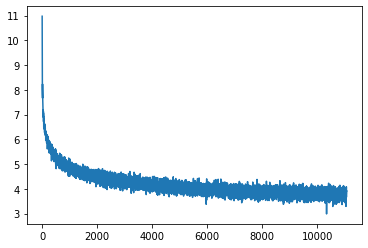

In [ ]:
plt.plot(range(1, len(train_loss)+1), train_loss)

## 学習させたモデルでテキスト生成してみる

In [ ]:
text = tokenizer.bos_token + " Her mother"
tokenized_ids = tokenizer(text).input_ids
with torch.no_grad():
    model.eval()
    while tokenized_ids[-1] != tokenizer.eos_token_id and len(tokenized_ids) < config.n_positions:
        logits = model(
            {
                'input_ids':torch.tensor([tokenized_ids]).to(device),
                'attention_mask':torch.ones(1, len(tokenized_ids)).to(device)
            }
        )
        tokenized_ids.append(torch.argmax(logits, dim=2)[0, -1].item())
    model.train()
print(tokenizer.decode(tokenized_ids))

<|endoftext|> Her mother, who was killed in a car crash in the city of Macerata, was killed in a crash in the city of Macerata.
The crash happened on the A445 near Macerata, near the scene of the crash, according to police.
The crash happened on the A174 near Macerata, near the scene of the crash.
The crash happened on the A174 near Macerata.
The crash is under investigation. <|endoftext|>


In [ ]:
text = tokenizer.bos_token + " Japan"
tokenized_ids = tokenizer(text).input_ids
with torch.no_grad():
    model.eval()
    while tokenized_ids[-1] != tokenizer.eos_token_id and len(tokenized_ids) < config.n_positions:
        logits = model(
            {
                'input_ids':torch.tensor([tokenized_ids]).to(device),
                'attention_mask':torch.ones(1, len(tokenized_ids)).to(device)
            }
        )
        tokenized_ids.append(torch.argmax(logits, dim=2)[0, -1].item())
    model.train()
print(tokenizer.decode(tokenized_ids))

<|endoftext|> Japan's Prime Minister Shinzo Abe has said he was not surprised to see the prospect of a major breakthrough in the country's economy.
The Japanese government said on Wednesday that the country's economy is a "good and stable economy", but the country's economy is a "good and stable economy", he said.
"The economy is a good thing for the economy, and the economy is a good thing for the economy," Abe said in a statement. "The economy is a good thing for the economy and the economy, and the economy is a good thing for the economy."
"The economy is a good thing for the economy
